# Example : Interrupted Time Series (ITS) with `pymc` models when the treatment time is unknown

This notebook demonstrates a new feature of the InterruptedTimeSeries class in CausalPy : it now supports models that can infer the treatment time directly from the data.
We illustrate this using a built-in model from the CausalPy library, which only requires specifying the effect of the intervention. From this, the model estimates when the intervention likely occurred.
The setting involves a single treated time series, without control units, and with only basic predictors such as time and calendar month.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp
from causalpy.data.simulate_data import (
    generate_time_series_data,
    generate_time_series_data_simple,
)

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

# Using the `InterventionTimeEstimator` PyMC model

The `ITE` model (`InterventionTimeEstimator`) is designed to infer the unknown intervention time based on the effect you specify. Instead of telling the model when the intervention happened, you describe what kind of effect you expect it had on the time series, although you can give a specific timerange for better precision.

Given a time series and a combination of user-defined effect (impulse, level shift, trend change), the model tries to find when such a change most likely occurred. It does this by evaluating how well different intervention times explain the observed data, using Bayesian inference.

### Narrowing the Inference Window

Instead of giving a treatment_time, you can restrict the inference to a range using time_range=(start, end), where start and end are the indexes of the dataframe you'll work with :

`model = ITE(time_range=(80,100), treatment_type_effect={"impulse":[]})` or `model = ITE(time_range=(pd.to_datetime("2016-01-31"),pd.to_datetime("2018-01-31")), treatment_type_effect={"impulse":[]})`

This can improve inference speed and stability, especially on noisy or long time series.

:::{tip}
If you’re unsure about the intervention period, try starting with time_range=None and inspect the posterior.
:::

### Specifying the effect

The effects can be specified using a dictionary passed to the `treatment_type_effect` arguments :

`model = ITE(time_range=None, treatment_type_effect={"level":[], "impulse":[mu, sigma1, sigma2]})`

:::{note}
You must provide all parameters if you choose to set them manually. If you leave the list empty ([]) or not fully furnished, default priors will be used.
:::

| Effect type | Description | Parameters required |
|-------------|-------------|---------------------|
|`level`| Permanent jump in the time series level | `[mu, sigma]` for N(mu, sigma) |
|`trend`| Change in the trend slope | `[mu, sigma]` for N(mu, sigma) |
|`impulse`| Sudden change with decay | `[mu, sigma1, sigma2]` where:<br> - Amplitude ~ N(mu, sigma1)<br> - decay ~ HalfNormal(sigma2) |


C:\Users\jeanv\Documents\Stage PYMC\CausalPy\causalpy\data\simulate_data.py:188: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\jeanv\AppData\Local\Temp\ipykernel_25932\652809254.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[]

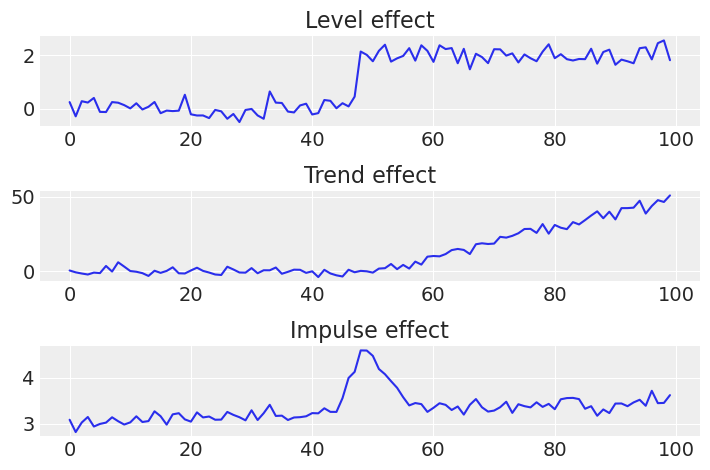

In [2]:
fig, ax = plt.subplots(3, 1)

# Level effect
df = generate_time_series_data_simple(treatment_time="2014-01-01")
ax[0].plot(np.arange(100), df["timeseries"][:100])
ax[0].set_title("Level effect")

# Trend effect
intervention_point = 50
time = np.arange(100)

pre_trend = np.zeros(intervention_point) + np.random.normal(
    scale=2, size=intervention_point
)
post_trend = (time[intervention_point:] - time[intervention_point]) + np.random.normal(
    scale=2, size=100 - intervention_point
)
y = np.concatenate([pre_trend, post_trend])

ax[1].plot(time, y)
ax[1].set_title("Trend effect")

# Impulse effect
df = generate_time_series_data(treatment_time=40, beta_temp=0)
ax[2].plot(df.index, df["deaths_actual"])
ax[2].set_title("Impulse effect")

plt.tight_layout()
plt.plot()

### Summary: How to use `ITE`

1. Determine which effects the intervention had (`impulse`, `level`, `trend`)

2. Choose wheter to:
    - leave parameters to default: `priors={"impulse": []}`
    - or specify priors: `priors={"impulse": [mu, sigma1, sigma2]}`

3. Optionally add `time_range=(start, end)` to narrow down inference.

4. Pass this model to InterruptedTimeSeries:

`ITS(df, treatment_time=None, formula="y ~ 1 + t + C(month)", model=ITE(...)`


# Interrupted Time Series (ITS) Example

Load data

In [2]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


Visualize the data

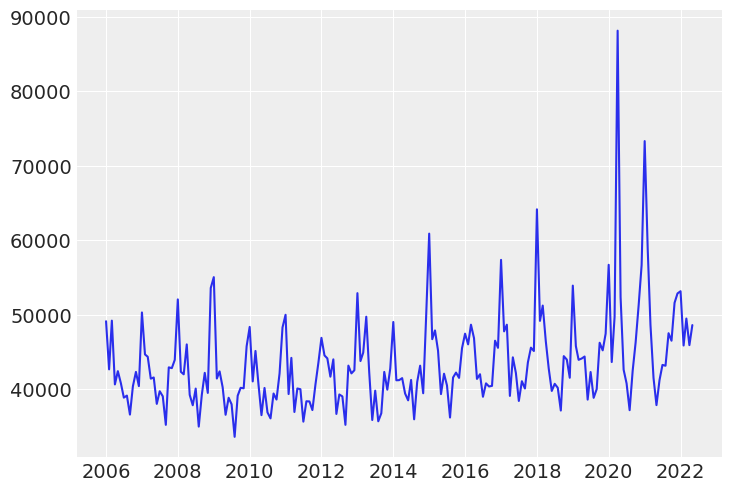

In [4]:
plt.plot(df.index, df["deaths"])

Looking at the data, we observe a noticeable increase in the number of deaths between yearss 2017 and 2019. After this period, the values seem to return to their previous level.

In this example, we will build a model using the "impulse" effect to represent this transient deviation. We won’t specify the exact location of the intervention; instead, the model will infer it from the data.

In [12]:
from causalpy.pymc_models import InterventionTimeEstimator as ITE

model = ITE(
    treatment_type_effect={"impulse": []},
    sample_kwargs={
        "max_treedepth": 15,
        "step_scale": 1,
        "target_accept": 0.90,
        "tune": 1000,
        "draws": 1000,
    },
)

Run the analysis

Optionally, instead of providing a fixed `treatment_time`, we can guide the inference by specifying a time_range as a tuple — for example, restricting the intervention to occur between years 2017 and 2019. Leaving `treatment_time=None` allows the model to search freely over all possible timestamps, but adding a constraint typically speeds up inference and focuses the posterior on plausible regions.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [13]:
from causalpy.experiments.interrupted_time_series import InterruptedTimeSeries as ITS

result = ITS(
    df,
    treatment_time=(pd.to_datetime("2016-01-01"), pd.to_datetime("2022-01-01")),
    formula="standardize(deaths) ~ 0 + t + C(month) + standardize(temp)",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_time, beta, impulse_amplitude, decay_rate, sigma, y_hat]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 459 seconds.
Sampling: [beta, decay_rate, impulse_amplitude, sigma, treatment_time, y_hat, y_ts]
Sampling: [y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]
Sampling: [y_hat, y_ts]


Plot the results

:::{note}

The model estimates the latent time series mu_hat by combining two components:

- `mu`: the part inferred from the user-defined formula (e.g. time + month),

- `mu_in`: the contribution from the intervention effect.

In the plots, we display only `mu` — the baseline prediction based on the formula — to better highlight the causal impact of the intervention. This makes it easier to see how the observed data diverge from what would be expected without the effect.

In contrast, evaluation metrics like R² and standard deviation are computed using `mu_hat`, which includes both the formula and the intervention effect.
As a result, R² may appear higher than what the plots suggest.
:::

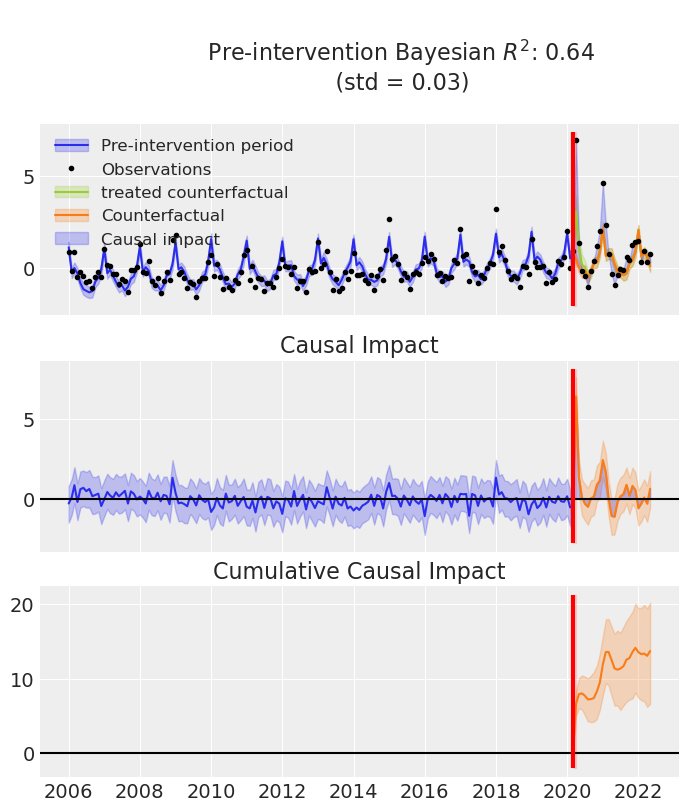

In [14]:
fig, ax = result.plot()

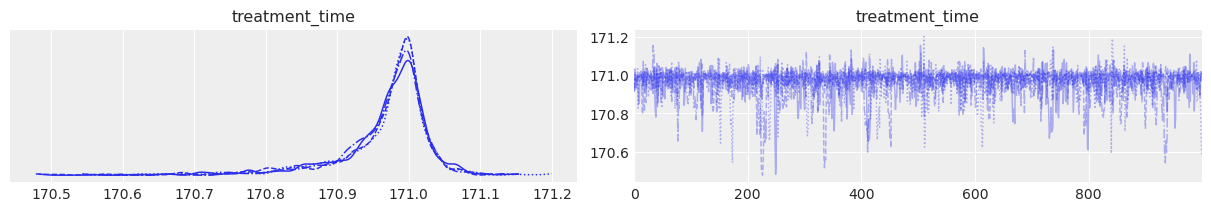

In [16]:
result.plot_treatment_time()

In [9]:
result.summary()

==================================Pre-Post Fit==================================
Formula: standardize(deaths) ~ 0 + t + C(month) + standardize(temp)
Model coefficients:
    C(month)[1]        0.81, 94% HDI [0.34, 1.3]
    C(month)[2]        -0.57, 94% HDI [-1, -0.081]
    C(month)[3]        -0.3, 94% HDI [-0.68, 0.11]
    C(month)[4]        -0.53, 94% HDI [-0.91, 0.0053]
    C(month)[5]        -0.74, 94% HDI [-1.1, -0.42]
    C(month)[6]        -0.88, 94% HDI [-1.4, -0.47]
    C(month)[7]        -0.79, 94% HDI [-1.4, -0.27]
    C(month)[8]        -1.1, 94% HDI [-1.6, -0.59]
    C(month)[9]        -0.97, 94% HDI [-1.4, -0.58]
    C(month)[10]       -0.65, 94% HDI [-0.98, -0.36]
    C(month)[11]       -0.69, 94% HDI [-1, -0.33]
    C(month)[12]       -0.33, 94% HDI [-0.79, 0.14]
    t                  0.0053, 94% HDI [0.0039, 0.0068]
    standardize(temp)  -0.22, 94% HDI [-0.52, 0.14]
    sigma              0.56, 94% HDI [0.46, 0.72]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [ ]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.18,0.134,-0.078,0.42,0.023,0.002,33.0,1479.0,1.08


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [ ]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,7.574,5.641,-3.286,17.654,0.978,0.073,33.0,1479.0,1.08
